In [12]:
using LinearAlgebra

t = 0
U = 1
chem_pot = 0
const N = 2
const states = reshape(Iterators.product([[0,1] for _ in 1:2N]...) .|> collect, (1, 2^(2N)))
const next = [collect(2:N); 1]


2-element Vector{Int64}:
 2
 1

In [2]:
struct StateVec
    label::Vector{Int64}
    values::Vector{Float64}
end

# pos = 2n - 1 up, 2n down; n = cell number
function create(vect, pos)
    if typeof(vect) == Int
        return 0
    end
    if vect[pos] == 1
        return 0
    end
    out = copy(vect)
    out[pos] = 1
    return out
end

function annihilate(vect, pos)
    if typeof(vect) == Int
        return 0
    end
    if vect[pos] == 0
        return 0
    end
    out = copy(vect)
    out[pos] = 0
    return out
end

up(cell_no) = Int(2cell_no - 1)
down(cell_no) = Int(2cell_no)

down (generic function with 1 method)

In [3]:
state_to_idx(state) = reduce(+, state .* [2^n for n in 0:length(state)-1]) + 1
state_to_statevec(state) = [x == state_to_idx(state) ? 1.0 : 0.0 for x in 1:(length(state))^2]

# H |state>
interacting_term(state, U, N) = U * reduce(+, [state[up(n)] * state[down(n)] for n in 1:N]) .* state_to_statevec(state)

function kinetic_term(state, t, next) 
    N = div(length(state), 2)
    total = zeros((2N)^2)
    for n in 1:(N)
        tmp1 = annihilate(state, up(next[n]))
        tmp2 = create(tmp1, up(n))
        if typeof(tmp2) != Int
            total[state_to_idx(tmp2)] += 1
        end
        tmp3 = annihilate(state, down(next[n]))
        tmp4 = create(tmp3, down(n))
        if typeof(tmp4) != Int
            total[state_to_idx(tmp4)] += 1
        end
    end
    return t * total
end

# perform H |state> and get statevec of: alpha |state'>
function hamiltonian_on_state(U, t, chem_pot, state, next)
    N = div(length(state), 2)
    # @show state
    interacting = interacting_term(state, U, N)
    # @show interacting
    kinetic = kinetic_term(state, t, next)
    # @show kinetic
    chemical = chem_pot * reduce(+, state) .* state_to_statevec(state)
    interacting + kinetic - chemical
end

normalize_statevec(statevec) = [x == 0 ? 0 : 1 for x in statevec]

function braket(bra, ket)
#     if normalize_statevec(bra) == normalize_statevec(ket)
        return dot(bra, ket)
#     else
#         return 0.0
#     end
end

# for every H |state> multiply it by every possible <state'|
function get_hamiltonian(states, U, t, chem_pot, next, N)
    hamiltonian = zeros((2N)^2, (2N)^2)
    right_side = [hamiltonian_on_state(U, t, chem_pot, state, next) for state in states]
    for i in 1:(2N)^2, j in 1:(2N)^2
        hamiltonian[i, j] = braket(state_to_statevec(states[i]), right_side[j])
    end
    hamiltonian
end

get_hamiltonian (generic function with 1 method)

In [4]:
state_vals_to_labels(state_vals) = [x != 0 ? x.* for (idx, x) in enumerate(state_vals)]

ErrorException: syntax: unexpected "]"

In [38]:
@show bra = state_to_statevec(states[13])
@show ket = hamiltonian_on_state(1, 1, 0, states[10], next)
braket(bra, ket)

bra = state_to_statevec(states[13]) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
ket = hamiltonian_on_state(1, 1, 0, states[10], next) = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


1.0

In [13]:
m = get_hamiltonian(states, U, t, chem_pot, next, N)

16×16 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [14]:
real(eigvals(m))

16-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 2.0

In [11]:
using DelimitedFiles
writedlm("matrix, mu=0txt", m)
writedlm("eigenvalues, mu=0.txt", real(eigvals(m)))

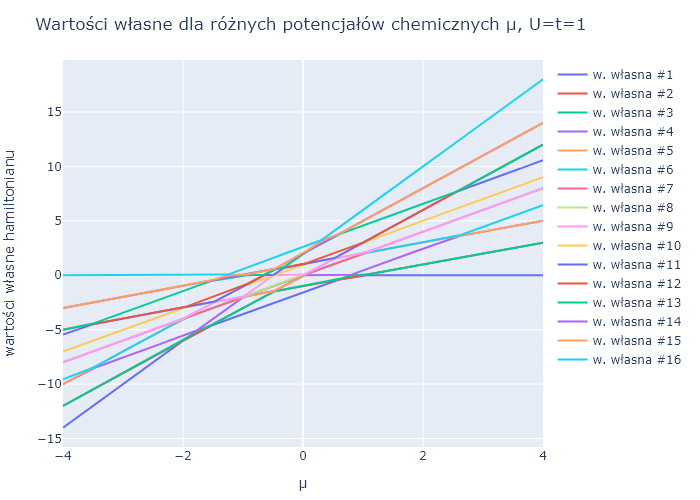

In [5]:
using PlotlyJS
potentials = collect(-4:0.01:4)
eigs_mat = reduce(hcat,[real(eigvals(get_hamiltonian(states, U, t, pot, next, N))) for pot in potentials])'
eigs_mat = [eigs_mat[:,i] for i in 1:size(eigs_mat,2)]
layout = Layout(
    title="Wartości własne dla różnych potencjałów chemicznych μ, U=t=1",
    xaxis_title="μ",
    yaxis_title="wartości własne hamiltonianu",
)
pl = plot([scatter(x=potentials, y=eig, name="w. własna #$no") for (eig, no) in zip(eigs_mat, 1:(2N)^2)], layout)

In [6]:
savefig(pl, "wartosci_wlasne.png")
savefig(pl, "wartosci_wlasne.html")

# oblożyć stanami op. liczby cząstek
# model t-J

"wartosci_wlasne.html"